This file gives the MSE of SFC-SAE with different latent variables. The detailed information can be seen at each individual file in SFC_SAE ipynbs folder. In addition, because the data in decoded_data folder and Error_data folder is too larger, they are not uploaded to Github repository. The detailed information of them can be found in the Readme.


## Mounting your google drive

You can use google drive to store and access files e.g. storing and loading data from numpy or CSV files.  
Use the following command to mount your GDrive and access your files.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install ffmpeg
!pip install vtk

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=362407a15fb020429f3e40042d321a079dc40a88cbbfdca95640a0667aac2401
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg
     |████████████████████████████████| 59.5 MB 40 kB/s 
     |████████████████████████████████| 3.1 MB 48.9 MB/s 
     |████████████████████████████████| 495 kB 78.7 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 3.2 MB 89.5 MB/s 
     |████████████████████████████████| 251 kB 76.3 MB/s 
     |████████████████████████████████| 1.3 MB 53.5 MB/s 
     |████████████████████████████████| 142 kB 96.0 MB/s 
     |████████████████████████████████| 294 kB 93.4 MB/s 


In [3]:
import os
# change the current path. The user can adjust the path depend on the requirement
os.chdir("/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF")
import vtktools

In [4]:
! /opt/bin/nvidia-smi

Sun Aug 22 12:42:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# !unzip csv_data.zip 

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import numpy.linalg as la
import scipy.linalg as sl
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import torch.nn as nn  # Neural network module
import scipy.sparse as sp
import scipy.optimize as sop
import progressbar
# making slopes
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from matplotlib.pyplot import LinearLocator
import matplotlib as mpl
import matplotlib.colors as colors


# create an animation
from matplotlib import animation
from IPython.display import HTML

from matplotlib import animation
import math
import ffmpeg

!pip install pycm livelossplot
%pylab inline
from livelossplot import PlotLosses

from torch.utils.data import DataLoader
import torch.utils.data as Data

import time
import platform
print('python version', platform.python_version())
print('torch version', torch.__version__)
print('numpy version', np.version.version)

     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 571 kB 32.2 MB/s 
Populating the interactive namespace from numpy and matplotlib
python version 3.7.11
torch version 1.9.0+cu102
numpy version 1.19.5


In [7]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cuda'  # Set out device to GPU

print('Cuda installed, running on GPU!')  # print sentence

Cuda installed, running on GPU!


In [8]:
# These functions are saved in function.py and the note are also added to that file
def saveIndex(path_train, path_valid, path_test,train_index, valid_index, test_index):    
    np.savetxt(path_train,train_index, delimiter=',')
    np.savetxt(path_valid,valid_index, delimiter=',')
    np.savetxt(path_test,test_index, delimiter=',')

def getIndex(path_train,path_valid,path_test):
    train_index = np.loadtxt(path_train,delimiter=",")
    valid_index = np.loadtxt(path_valid,delimiter=",")
    test_index = np.loadtxt(path_test,delimiter=",")
    return train_index,valid_index,test_index

def saveMode(path_train, path_valid, path_test,mode_train, mode_valid, mode_test):    
    np.savetxt(path_train,mode_train.cpu().data.numpy(), delimiter=',')
    np.savetxt(path_valid,mode_valid.cpu().data.numpy(), delimiter=',')
    np.savetxt(path_test,mode_test.cpu().data.numpy(), delimiter=',')

def getMode(path_train,path_valid,path_test):
    mode_train = np.loadtxt(path_train,delimiter=",")
    mode_valid = np.loadtxt(path_valid,delimiter=",")
    mode_test = np.loadtxt(path_test,delimiter=",")
    return mode_train,mode_valid,mode_test

def saveCsv(pathcsv,EPOCH):
    losses_combined = np.zeros((EPOCH,3))
    losses_combined[:,0] = np.asarray(epoch_list)
    losses_combined[:,1] = np.asarray(loss_list)
    losses_combined[:,2] = np.asarray(loss_valid)
    np.savetxt(pathcsv, losses_combined , delimiter=',')


def PlotMSELoss(pathName,name):
    data = np.loadtxt(pathName,delimiter=",")
    epoch = data[:,0]
    train_loss = data[:,1]
    val_loss = data[:,2]

    fig = plt.figure(figsize=(10,7))
    axe1 = plt.subplot(111)
    axe1.semilogy(epoch,train_loss,label = "train")
    axe1.plot(epoch,val_loss,label = "valid")
    axe1.legend(loc = "best",fontsize=14)
    axe1.set_xlabel("$epoch$",fontsize=14)
    axe1.set_ylabel("$MSE loss$",fontsize=14)
    axe1.set_title(name,fontsize=14)


def getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index):
    total_decoded = np.zeros((nTotal,nNodes,2))
    for i in range(len(train_index)):
        total_decoded[int(train_index[i]),:,0] = training_decoded.cpu().detach().numpy()[i,:,0]
        total_decoded[int(train_index[i]),:,1] = training_decoded.cpu().detach().numpy()[i,:,1]

    for i in range(len(valid_index)):
        total_decoded[int(valid_index[i]),:,0] = valid_decoded.cpu().detach().numpy()[i,:,0]
        total_decoded[int(valid_index[i]),:,1] = valid_decoded.cpu().detach().numpy()[i,:,1]

    for i in range(len(test_index)):
        total_decoded[int(test_index[i]),:,0] = test_decoded.cpu().detach().numpy()[i,:,0]
        total_decoded[int(test_index[i]),:,1] = test_decoded.cpu().detach().numpy()[i,:,1]
    return total_decoded

def getMSELoss(pathName):
    epoch = pd.read_csv(pathName,usecols=[0]).values
    train_loss = pd.read_csv(pathName,usecols=[1]).values
    val_loss = pd.read_csv(pathName,usecols=[2]).values
    return train_loss,val_loss,epoch


def index_split(train_ratio, valid_ratio, test_ratio, total_num):
    if train_ratio + valid_ratio + test_ratio != 1:
        raise ValueError("Three input ratio should sum to be 1!")
    total_index = np.arange(total_num)
    rng = np.random.default_rng()
    total_index = rng.permutation(total_index)
    knot_1 = int(total_num * train_ratio)
    knot_2 = int(total_num * valid_ratio) + knot_1
    train_index, valid_index, test_index = np.split(total_index, [knot_1, knot_2])
    return train_index, valid_index, test_index

In [9]:
path_train = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"new_FPC_train_index.csv"
path_valid = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"new_FPC_valid_index.csv"
path_test = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"new_FPC_test_index.csv"
# saveIndex(path_train, path_valid, path_test,train_index, valid_index, test_index)

In [10]:
# Load the train_index, valid_index and test_index
train_index,valid_index,test_index= getIndex(path_train,path_valid,path_test)
print(test_index)

[ 133.  490. 1480.  730.  481. 1382.  440.  750. 1502. 1451.  692. 1094.
 1679.  510. 1241. 1101.  543. 1312. 1432. 1988. 1148. 1801. 1519.  367.
 1858. 1043. 1175. 1218. 1479.  103. 1363.  800.  258. 1851.  267.  999.
  611. 1824.  318.  753. 1413.  727. 1273. 1358. 1090.  838.  250. 1763.
 1038.  439. 1199.  334. 1848. 1924. 1013.  271.  936.  600. 1553.  423.
 1467. 1658.  929. 1748.  783.  329.  303. 1067.  868.  374. 1102. 1843.
  683.  449.  855. 1142. 1393.  194. 1112.  636. 1617. 1910. 1722.  536.
 1149. 1765.  468. 1922. 1703. 1311.  341.  110. 1258. 1257. 1711.   93.
 1969.  396. 1259.  199.  962. 1704.  462. 1407.  634.  535. 1505.  537.
  612. 1707. 1565. 1963. 1955.    3. 1058. 1946.  372. 1653. 1077.  414.
  469.  680. 1430.  649.  215.  234. 1692.  653. 1455.  582. 1169. 1138.
  411.  518.  865. 1977. 1688.  822.  397. 1388. 1221.  239.  249. 1781.
 1751.  915.  278. 1970.  907.  477. 1552.  703.  870.  916. 1650.  561.
 1401.  129. 1123. 1804. 1871. 1527.  308.   94. 19

# load data

In [11]:
os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
print(os.getcwd())

# read in the data (1000 csv files)
nTrain = 1600
nValid = 200
nTest = 200
nTotal = nTrain + nValid + nTest
nNodes = 20550 # should really work this out


# The below method to load data is too slow. Therefore, we use load pt file

# [:, :, 2] is speed, [:, :, 3] is u, [:, :, 4] is v
# (speed not really needed)
# [:, :, 0] and [:, :, 1] are the SFC orderings

# training_data = np.zeros((nTrain,nNodes,5))
# for i in range(nTrain):
#     data = np.loadtxt('csv_data/data_' +str(int(train_index[i]))+ '.csv', delimiter=',')
#     training_data[i,:,:] = data
# training_data = np.array(training_data)
# print('size training data', training_data.shape)

# valid_data = np.zeros((nValid,nNodes,5))
# for i in range(nValid):
#     data = np.loadtxt('csv_data/data_' +str(int(valid_index[i]))+ '.csv', delimiter=',')
#     valid_data[i,:,:] = data
# valid_data = np.array(valid_data)
# print('size validation data', valid_data.shape)

# test_data = np.zeros((nTest,nNodes,5))
# for i in range(nTest):
#     data = np.loadtxt('csv_data/data_' +str(int(test_index[i]))+ '.csv', delimiter=',')
#     test_data[i,:,:] = data
# test_data = np.array(test_data)
# print('size test data', test_data.shape)

# total_data = np.zeros((nTotal,nNodes,5))
# for i in range(len(train_index)):
#     total_data[int(train_index[i]),:,:] = training_data[i,:,:]

# for i in range(len(valid_index)):
#     total_data[int(valid_index[i]),:,:] = valid_data[i,:,:]

# for i in range(len(test_index)):
#     total_data[int(test_index[i]),:,:] = test_data[i,:,:]
# print('size total data', total_data.shape)



/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF


In [12]:
# torch.save(training_data, '/content/gdrive/MyDrive/FPC_new_random_train.pt')
# torch.save(valid_data, '/content/gdrive/MyDrive/FPC_new_random_valid.pt')
# torch.save(test_data, '/content/gdrive/MyDrive/FPC_new_random_test.pt')
# torch.save(total_data, '/content/gdrive/MyDrive/FPC_new_random_total.pt')

In [13]:
# load the data, this method save the time
training_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_train.pt')
valid_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_valid.pt')
test_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_test.pt')
total_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_total.pt')
print(training_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(total_data.shape)

(1600, 20550, 5)
(200, 20550, 5)
(200, 20550, 5)
(2000, 20550, 5)


In [14]:
# rescale the data so that u and v data lies in the range [-1,1] (and speed in [0,1])
ma = np.max(training_data[:, :, 2])
mi = np.min(training_data[:, :, 2])
k = 1./(ma - mi)
b = 1 - k*ma #k*mi
training_data[:, :, 2] = k * training_data[:, :, 2] + b #- b
# this won't be used

ma = np.max(training_data[:, :, 3])
mi = np.min(training_data[:, :, 3])
ku = 2./(ma - mi)
bu = 1 - ku*ma 
training_data[:, :, 3] = ku * training_data[:, :, 3] + bu
valid_data[:, :, 3] = ku * valid_data[:, :, 3] + bu
test_data[:, :, 3] = ku * test_data[:, :, 3] + bu
total_data[:, :, 3] = ku * total_data[:, :, 3] + bu

ma = np.max(training_data[:, :, 4])
mi = np.min(training_data[:, :, 4])
kv = 2./(ma - mi)
bv = 1 - kv*ma
training_data[:, :, 4] = kv * training_data[:, :, 4] + bv
valid_data[:, :, 4] = kv * valid_data[:, :, 4] + bv
test_data[:, :, 4] = kv * test_data[:, :, 4] + bv
total_data[:, :, 4] = kv * total_data[:, :, 4] + bv

# Sequential autoencoder

## Network architetcure

### First subnetwork

In [15]:
# Standard
class CNN_1(nn.Module):
    def __init__(self,hidden_1):
        super(CNN_1, self).__init__()
        self.encoder_h1 = nn.Sequential(
            # input shape (16,4,20550)  # The first 16 is the batch size
            nn.Tanh(),
            nn.Conv1d(4, 8, 16, 4, 9),
            # output shape (16, 8, 5139)
            nn.Tanh(),
            nn.Conv1d(8, 8, 16, 4, 9),
            # output shape (16, 8,1286)
            nn.Tanh(),
            nn.Conv1d(8, 16, 16, 4, 9),
            # output shape (16,16,323)
            nn.Tanh(),
            nn.Conv1d(16, 16,16, 4, 9),
            # output shape (16, 16, 82)
            nn.Tanh(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16*82, hidden_1),
            nn.Tanh(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_1, 16*82),
            nn.Tanh(),
        )
        self.decoder_h1 = nn.Sequential(
            # (b, 16, 81)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 17, 4, 9), # (16, 16, 323)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 8, 16, 4, 9), # (16, 8, 1286)
            nn.Tanh(),
            nn.ConvTranspose1d(8, 8, 17, 4, 9), # (16, 8, 5139)
            nn.Tanh(),
            nn.ConvTranspose1d(8, 4, 16, 4, 9), # (16, 4, 20550)
            nn.Tanh(),
        )

        # input sparse layers, initialize weight as 0.33, bias as 0
        self.weight1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight11 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias11 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight2 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight22 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias22 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        
        # output sparse layers, initialize weight as 0.083, bias as 0
        self.weight_out1 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out1_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out1_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out11 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out11_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out11_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out2 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out22 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out3 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out33 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out4 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out44 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.bias_out1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.bias_out2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)


    def forward(self, x):
        # print("X_size",x.size())
        # first curve
        ToSFC1 = x[:, :, 0] # The first column is the first SFC ordering
        ToSFC1Up = torch.zeros_like(ToSFC1)
        ToSFC1Down = torch.zeros_like(ToSFC1)
        ToSFC1Up[:-1] = ToSFC1[1:]
        ToSFC1Up[-1] = ToSFC1[-1]
        ToSFC1Down[1:] = ToSFC1[:-1]
        ToSFC1Down[0] = ToSFC1[0]

        batch_num = ToSFC1.shape[0]
        #print("ToSFC1",ToSFC1.shape) # (16, 20550)
        x1 = x[:, :, 3:5] # The fourth column and fifth column are velocities u and v respectively
        #print("x1", x1.shape) #        # (16, 20550, 2)
        x1_1d = torch.zeros((batch_num, 4, k)).to(device)
        # first input sparse layer, then transform to sfc order1
        for j in range(batch_num):
            x1_1d[j, 0, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight1 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight1_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight1_1 + self.bias1
        
            x1_1d[j, 1, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight11 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight11_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight11_1 + self.bias11

            x1_1d[j, 2, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight2 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight2_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight2_1 + self.bias2

            x1_1d[j, 3, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight22 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight22_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight22_1 + self.bias22

        # first cnn encoder
        encoded_1 = self.encoder_h1(x1_1d.view(-1, 4, k)) #(16,4,20550)
        # print("encoded", encoded_1.shape)
        # flatten and concatenate
        encoded_3 = encoded_1.view(-1,16*82)
        # print("Before FC", encoded_3.shape)
        # fully connection
        encoded = self.fc1(encoded_3) # (b,64)
        # print("After encoder FC，the output of encoder",encoded.shape)  # [16,128]
        # 直接输出decoder
        decoded_3 = self.decoder_h1(self.fc2(encoded).view(-1, 16, 82))
        # print("The output of decoder: ", decoded_3.shape) # (16, 2, 20550)
        BackSFC1 = torch.argsort(ToSFC1)
        BackSFC1Up = torch.argsort(ToSFC1Up)
        BackSFC1Down = torch.argsort(ToSFC1Down)

        decoded_sp = torch.zeros((batch_num, k, 2)).to(device)
        # output sparse layer, resort according to sfc transform
        for j in range(batch_num):
            decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
                                  decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
                                  decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1 + \
                                  decoded_3[j, 1, :][BackSFC1[j].long()]* self.weight_out11 + \
                                  decoded_3[j, 1, :][BackSFC1Up[j].long()] * self.weight_out11_0 + \
                                  decoded_3[j, 1, :][BackSFC1Down[j].long()] * self.weight_out11_1 + self.bias_out1

            decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
                                  decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
                                  decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
                                  decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
                                  decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
                                  decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2 
        
        # resort 1D to 2D
        decoded = F.tanh(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        return encoded, decoded

### Second subnetwork 

In [16]:
class CNN_2(nn.Module):
    def __init__(self,hidden_2):
        super(CNN_2, self).__init__()
        self.encoder_h1 = nn.Sequential(
            # input shape (16,4,20550)
            nn.Tanh(),
            nn.Conv1d(4, 16, 32, 4, 16),
            # output shape (16, 16, 5138)
            nn.Tanh(),
            nn.Conv1d(16, 16, 32, 4, 16),
            # output shape (16, 16,1285)
            nn.Tanh(),
            nn.Conv1d(16, 16, 32, 4, 16),
            # output shape (16,16,322)
            nn.Tanh(),
            nn.Conv1d(16, 16, 32, 4, 16),
            # output shape (16,16,81)
            nn.Tanh(),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(1296, hidden_2),
            nn.Tanh(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_2, 16*81),
            nn.Tanh(),
        )
        self.decoder_h1 = nn.Sequential(
            # (b, 16, 81)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 15), # (16, 16, 322)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 15), # (16, 16, 1286)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 16), # (16, 16, 5140)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 4, 32, 4, 19), # (16, 4, 20550)
            nn.Tanh(),
        )

        # input sparse layers, initialize weight as 0.33, bias as 0
        self.weight1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight11 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias11 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight2 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight22 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias22 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        
        # output sparse layers, initialize weight as 0.083, bias as 0
        self.weight_out1 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out1_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out1_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out11 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out11_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out11_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out2 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out22 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out3 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out33 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out4 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out44 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.bias_out1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.bias_out2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)


    def forward(self, x):
        # print("X_size",x.size())
        # first curve
        ToSFC1 = x[:, :, 0] # # The first column is the first SFC ordering
        ToSFC1Up = torch.zeros_like(ToSFC1)
        ToSFC1Down = torch.zeros_like(ToSFC1)
        ToSFC1Up[:-1] = ToSFC1[1:]
        ToSFC1Up[-1] = ToSFC1[-1]
        ToSFC1Down[1:] = ToSFC1[:-1]
        ToSFC1Down[0] = ToSFC1[0]

        batch_num = ToSFC1.shape[0]
        #print("ToSFC1",ToSFC1.shape) # (16, 20550)
        x1 = x[:, :, 3:5] # u and v
        #print("x1", x1.shape) #        # (16, 20550, 2)
        x1_1d = torch.zeros((batch_num, 4, k)).to(device)
        # first input sparse layer, then transform to sfc order1
        for j in range(batch_num):
            x1_1d[j, 0, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight1 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight1_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight1_1 + self.bias1
        
            x1_1d[j, 1, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight11 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight11_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight11_1 + self.bias11

            x1_1d[j, 2, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight2 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight2_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight2_1 + self.bias2

            x1_1d[j, 3, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight22 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight22_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight22_1 + self.bias22

        # first cnn encoder
        encoded_1 = self.encoder_h1(x1_1d.view(-1, 4, k)) #(16,4,20550)
        # print("encoded", encoded_1.shape)
        # flatten and concatenate
        encoded_3 = encoded_1.view(-1,16*81)
        # print("Before FC", encoded_3.shape)
        # fully connection
        encoded = self.fc1(encoded_3) # (b,128)
        # print("After encoder FC，the output of encoder",encoded.shape)     
        # encoded = torch.cat((encoded, mode),axis = 1)  # Combine the mode_1 to the x1
        
        # print("encoded_combine",encoded.shape)
        decoded_3 = self.decoder_h1(self.fc2(encoded).view(-1, 16, 81))
        # print("The output of decoder: ", decoded_3.shape) # (16, 2, 20550)
        BackSFC1 = torch.argsort(ToSFC1)
        BackSFC1Up = torch.argsort(ToSFC1Up)
        BackSFC1Down = torch.argsort(ToSFC1Down)

        # k = 20550
        # batch_num = ToSFC1.shape[0]
        decoded_sp = torch.zeros((batch_num, k, 2)).to(device)
        # output sparse layer, resort according to sfc transform
        for j in range(batch_num):
            decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
                                  decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
                                  decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1 + \
                                  decoded_3[j, 1, :][BackSFC1[j].long()]* self.weight_out11 + \
                                  decoded_3[j, 1, :][BackSFC1Up[j].long()] * self.weight_out11_0 + \
                                  decoded_3[j, 1, :][BackSFC1Down[j].long()] * self.weight_out11_1 + self.bias_out1

            decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
                                  decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
                                  decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
                                  decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
                                  decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
                                  decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2       
        # resort 1D to 2D
        decoded = F.tanh(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        return encoded, decoded

## Variable 2

### Save and load error

In [ ]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 1 latent variables
print("compress to 1")
Latent_num = 1
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran3000_LV1_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

In [16]:

Latent_num = 1
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV1_Eran3000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV1_Eran3000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [17]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [18]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [20]:
# SFC-SAE: one curve with nearest neighbour smoothing and compressing to 2 latent variables
print("compress to 2")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 2
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5

# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 2
(1600, 20550, 5)


In [24]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error3000_LV2_B16_n1600_L0.0001.pkl")


# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0016803756250493341
Mse of validation data 0.0023837184200220787
Mse of test data 0.0020436234552424345
torch.Size([1600, 1])
torch.Size([200, 1])
torch.Size([200, 1])


In [25]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

Reconstruction : 7.337416172027588


In [26]:
train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())

MSE_err of training data 0.0016803756250287414
MSE_err of valid data 0.002383718420117703
MSE_err of test data 0.0020436234549194255


### Plot loss

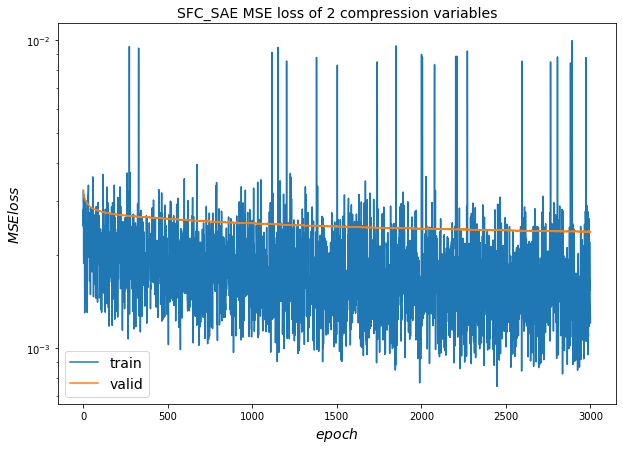

In [28]:
pathName = "./SAE/csv/II_I_Error3000_LV2_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 2 compression variables"
PlotMSELoss(pathName,name)

## Variable 4

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 2 latent variables
print("compress to 2")
Latent_num = 2
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 2
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran3000_LV2_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.001714568090496204
Mse of validation data 0.001626924338413215
Mse of test data 0.0015190790404827452
Mse of total data 0.0016862548102865615
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [18]:
Latent_num = 2
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV2_Eran3000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV2_Eran3000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [19]:

training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [20]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [21]:
# SFC-SAE: one curve with nearest neighbour smoothing and compressing to 4 latent variables
print("compress to 4")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 4
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5


# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 4
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error3000_LV4_B16_n1600_L0.0001.pkl")


# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0009525349446919118
Mse of validation data 0.0010357036100502076
Mse of test data 0.0009900677909595213
torch.Size([1600, 2])
torch.Size([200, 2])
torch.Size([200, 2])


In [23]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.0009525349446794082
MSE_err of valid data 0.0010357036102342553
MSE_err of test data 0.0009900677908141835
Reconstruction : 7.265318155288696


### Plot loss

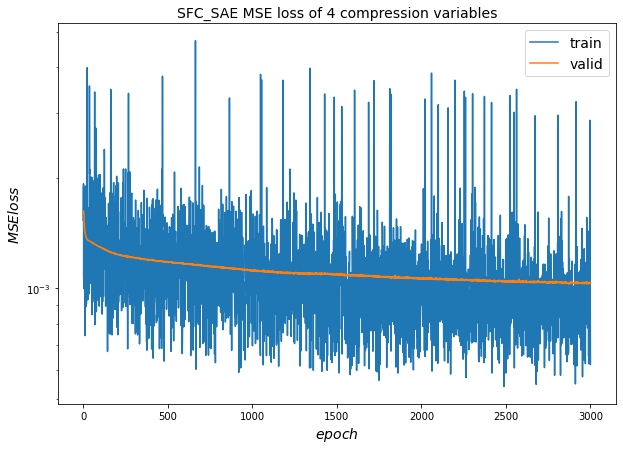

In [25]:
pathName = "./SAE/csv/II_I_Error3000_LV4_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 4 compression variables"
PlotMSELoss(pathName,name)

## Variable 8

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 4 latent variables
print("compress to 4")
Latent_num = 4
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 4
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran3000_LV4_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.001800290672928284
Mse of validation data 0.0016793311961709567
Mse of test data 0.0016060082243134072
Mse of total data 0.0017687664803910583
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [18]:
Latent_num = 4
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV4_Eran3000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV4_Eran3000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [19]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)

Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [20]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)

size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [21]:
# SFC-SAE: one curve with nearest neighbour smoothing and compressing to 8 latent variables
print("compress to 8")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 8
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5

# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 8
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error2000_LV8_B16_n1600_L0.0001.pkl")

# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0009129567734057727
Mse of validation data 0.0009490436174231188
Mse of test data 0.0008842157700134193
torch.Size([1600, 4])
torch.Size([200, 4])
torch.Size([200, 4])


In [23]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.0009129567732626516
MSE_err of valid data 0.0009490436172954912
MSE_err of test data 0.0008842157699789986
Reconstruction : 7.775551080703735


### Plot loss

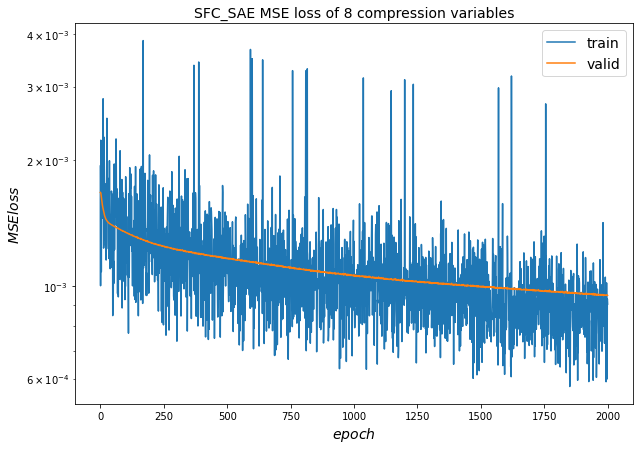

In [26]:
pathName = "./SAE/csv/II_I_Error2000_LV8_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 8 compression variables"
PlotMSELoss(pathName,name)

## Variable 16

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 8 latent variables
print("compress to 8")
Latent_num = 8
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 8
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV8_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0007750525332654719
Mse of validation data 0.0007295926833775455
Mse of test data 0.000719623800960846
Mse of total data 0.0007649636750462172
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [18]:
Latent_num = 8
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV8_Eran2000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV8_Eran2000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [19]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [20]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [21]:
# SFC-SAE: one curve with nearest neighbour smoothing and compressing to 16 latent variables
print("compress to 16")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 16
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5


# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 16
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error2000_LV16_B16_n1600_L0.0001.pkl")

# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.00044874014909210394
Mse of validation data 0.00044882930210509087
Mse of test data 0.0004299093814631644
torch.Size([1600, 8])
torch.Size([200, 8])
torch.Size([200, 8])


In [23]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.000448740149085171
MSE_err of valid data 0.00044882930208607716
MSE_err of test data 0.00042990938127549866
Reconstruction : 7.682904005050659


### Plot loss

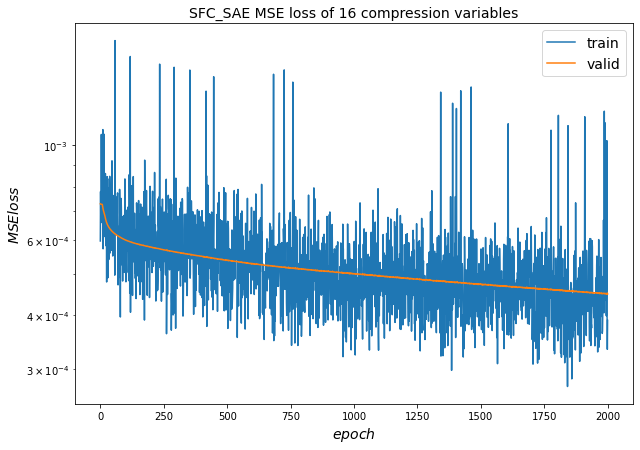

In [27]:
pathName = "./SAE/csv/II_I_Error2000_LV16_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 16 compression variables"
PlotMSELoss(pathName,name)

## Variable 32

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 16 latent variables
print("compress to 16")
Latent_num = 16
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 16
(1600, 20550, 5)


In [18]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV16_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0005865264995672188
Mse of validation data 0.0005631336181661614
Mse of test data 0.0005540129282921709
Mse of total data 0.0005809358542996067
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [19]:
Latent_num = 16
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV16_Eran2000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV16_Eran2000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [20]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [21]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [22]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 32 latent variables
print("compress to 32")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 32
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5


# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 32
(1600, 20550, 5)


In [23]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error2000_LV32_B16_n1600_L0.0001.pkl")


# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.000302289311189244
Mse of validation data 0.0002984212693979902
Mse of test data 0.00028993085220463557
torch.Size([1600, 16])
torch.Size([200, 16])
torch.Size([200, 16])


In [24]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.0003022893111780763
MSE_err of valid data 0.00029842126951532997
MSE_err of test data 0.0002899308521473055
Reconstruction : 7.047347784042358


### Plot loss

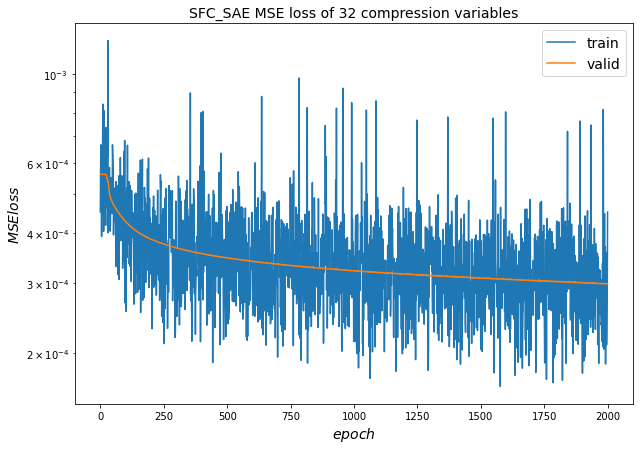

In [28]:
pathName = "./SAE/csv/II_I_Error2000_LV32_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 32 compression variables"
PlotMSELoss(pathName,name)

## Variable 64

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 32 latent variables
print("compress to 32")
Latent_num = 32
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 32
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV32_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.00043976261054398495
Mse of validation data 0.0004301108942808768
Mse of test data 0.00042198910197026974
Mse of total data 0.0004370200880603037
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [18]:
Latent_num = 32
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV32_Eran2000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV32_Eran2000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [19]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [20]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [21]:
# SFC-SAE: one curve with nearest neighbour smoothing and compressing to 64 latent variables
print("compress to 64")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 64
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5


# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 64
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error2000_LV64_B16_n1600_L0.0001.pkl")

# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0002079766117360094
Mse of validation data 0.0002101146672667781
Mse of test data 0.00020169885436399393
torch.Size([1600, 32])
torch.Size([200, 32])
torch.Size([200, 32])


In [23]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.00020797661167523893
MSE_err of valid data 0.00021011466721676127
MSE_err of test data 0.0002016988543510715
Reconstruction : 5.2889204025268555


### Plot loss

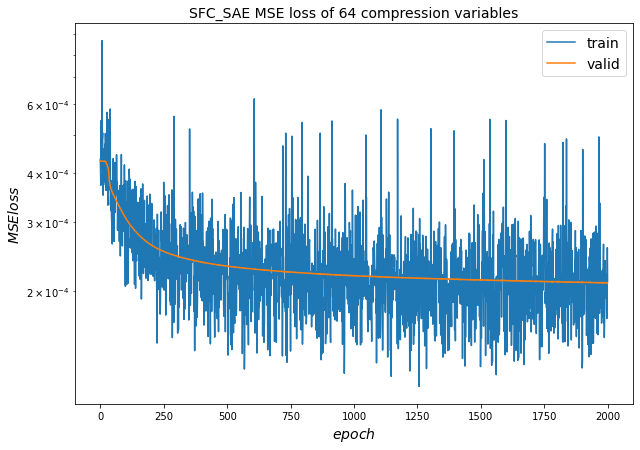

In [29]:
pathName = "./SAE/csv/II_I_Error2000_LV64_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 64 compression variables"
PlotMSELoss(pathName,name)

## Variable 128

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 64 latent variables
print("compress to 64")
Latent_num = 64
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 64
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV64_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.00033798539288099413
Mse of validation data 0.0003331407982756795
Mse of test data 0.00032475587941217576
Mse of total data 0.00033617798207358343
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [18]:
Latent_num = 64
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV64_Eran2000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV64_Eran2000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [19]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [20]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [21]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 128 latent variables
print("compress to 128")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 128
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5


# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 128
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error2000_LV128_B16_n1600_L0.0001.pkl")

# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.0001461413590366402
Mse of validation data 0.00014670909650866076
Mse of test data 0.00014104510983224415
torch.Size([1600, 64])
torch.Size([200, 64])
torch.Size([200, 64])


In [23]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.0001461413590430844
MSE_err of valid data 0.00014670909642857597
MSE_err of test data 0.00014104510986346727
Reconstruction : 7.65171217918396


### Plot loss

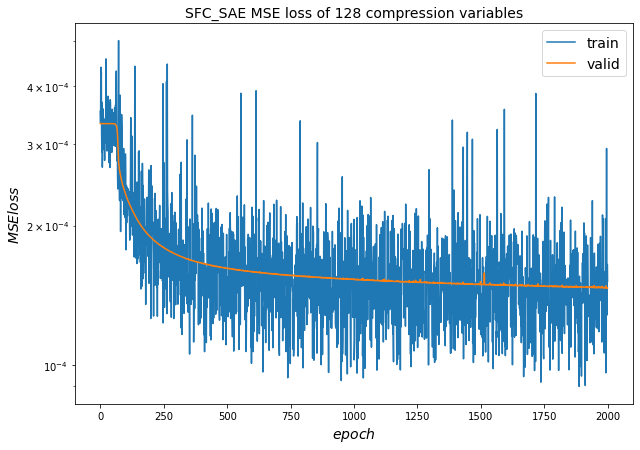

In [30]:
pathName = "./SAE/csv/II_I_Error2000_LV128_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 128 compression variables"
PlotMSELoss(pathName,name)

## Variable 256

### Save and load error

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 128 latent variables
print("compress to 128")
Latent_num = 128
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle= True)

compress to 128
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV128_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error1 = (training_data[:,:,3:5] - training_decoded.cpu().detach().numpy())
# print("MSE of training data", (train_error1**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error1 = (valid_data[:, :, 3:5] - valid_decoded.cpu().detach().numpy())
# print("Mse of validation data", (valid_error1**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error1 = (test_data[:, :, 3:5]- test_decoded.cpu().detach().numpy())
# print("Mse of test data", (test_error1**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error1 = (total_data[:, :, 3:5] - total_decoded)
# print("Mse of total data", (total_error1**2).mean())

# print(train_error1.shape)
# print(valid_error1.shape)
# print(test_error1.shape)
# print(total_error1.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.00030399716480860917
Mse of validation data 0.00029692828674264874
Mse of test data 0.00029259376693565394
Mse of total data 0.0003021499372147189
(1600, 20550, 2)
(200, 20550, 2)
(200, 20550, 2)
(2000, 20550, 2)


In [18]:
Latent_num = 128
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_decoded = "./SAE/decoded_data/II_decoded_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_decoded)


path_train_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.pt"
path_valid_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.pt"
path_test_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.pt"
path_total_error = "./SAE/Error_data/II_error_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_total.pt"
print(path_total_error)


./SAE/decoded_data/II_decoded_LV128_Eran2000_B16_n1600_L0.0001_total.pt
./SAE/Error_data/II_error_LV128_Eran2000_B16_n1600_L0.0001_total.pt


In [ ]:
# torch.save(training_decoded, path_train_decoded)
# torch.save(valid_decoded, path_valid_decoded)
# torch.save(test_decoded, path_test_decoded)
# torch.save(total_decoded, path_total_decoded)

# torch.save(train_error1, path_train_error)
# torch.save(valid_error1, path_valid_error)
# torch.save(test_error1, path_test_error)
# torch.save(total_error1, path_total_error)

In [19]:
training_decoded = torch.load(path_train_decoded)
valid_decoded = torch.load(path_valid_decoded)
test_decoded = torch.load(path_test_decoded)
total_decoded = torch.load(path_total_decoded)

train_error1 = torch.load(path_train_error)
valid_error1 = torch.load(path_valid_error)
test_error1 = torch.load(path_test_error)
total_error1 = torch.load(path_total_error)

print('Train decode: ',training_decoded.shape)
print('Valid decode: ', valid_decoded.shape)
print('Test decode: ',test_decoded.shape)
print('Total decode: ',total_decoded.shape)

print('Train error: ',train_error1.shape)
print('Valid error: ',valid_error1.shape)
print('Test error: ',test_error1.shape)
print('Total error: ',total_error1.shape)


Train decode:  torch.Size([1600, 20550, 2])
Valid decode:  torch.Size([200, 20550, 2])
Test decode:  torch.Size([200, 20550, 2])
Total decode:  (2000, 20550, 2)
Train error:  (1600, 20550, 2)
Valid error:  (200, 20550, 2)
Test error:  (200, 20550, 2)
Total error:  (2000, 20550, 2)


In [20]:
# Add the SFC ordering to the residual data
training_error = np.zeros((nTrain,nNodes,5))
training_error[:,:,0] = training_data[:,:,0]
training_error[:,:,1] = training_data[:,:,1]
training_error[:,:,2] = training_data[:,:,2]
training_error[:,:,3] = train_error1[:,:,0]
training_error[:,:,4] = train_error1[:,:,1]


valid_error = np.zeros((nValid,nNodes,5))
valid_error[:,:,0] = valid_data[:,:,0]
valid_error[:,:,1] = valid_data[:,:,1]
valid_error[:,:,2] = valid_data[:,:,2]
valid_error[:,:,3] = valid_error1[:,:,0]
valid_error[:,:,4] = valid_error1[:,:,1]

test_error = np.zeros((nTest,nNodes,5))
test_error[:,:,0] = test_data[:,:,0]
test_error[:,:,1] = test_data[:,:,1]
test_error[:,:,2] = test_data[:,:,2]
test_error[:,:,3] = test_error1[:,:,0]
test_error[:,:,4] = test_error1[:,:,1]


total_error = np.zeros((nTrain+nValid+nTest,nNodes,5))
total_error[:,:,0] = total_data[:,:,0]
total_error[:,:,1] = total_data[:,:,1]
total_error[:,:,2] = total_data[:,:,2]
total_error[:,:,3] = total_error1[:,:,0]
total_error[:,:,4] = total_error1[:,:,1]


print('size train error', training_error.shape)
print('size valid error', valid_error.shape)
print('size test error', test_error.shape)
print('size total error', total_error.shape)


size train error (1600, 20550, 5)
size valid error (200, 20550, 5)
size test error (200, 20550, 5)
size total error (2000, 20550, 5)


### Load model and calculate MSE

In [21]:
# SFC-SAE: one curve with nearest neighbour smoothing and compressing to 256 latent variables
print("compress to 256")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 256
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_error.shape) # nTrain by number of nodes by 5


# Residual as the input
# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_error, batch_size =BATCH_SIZE , shuffle = True)

compress to 256
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./SAE/pkl/II_I_Error2000_LV256_B16_n1600_L0.0001.pkl")

# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded2 = autoencoder_2.to(device)(torch.tensor(training_error).to(device))
mode_2valid, valid_decoded2 = autoencoder_2.to(device)(torch.tensor(valid_error).to(device))
mode_2test, test_decoded2 = autoencoder_2.to(device)(torch.tensor(test_error).to(device))
t_predict_1 = time.time()

train_error2 = (training_decoded2.cpu().detach().numpy() - training_error[:,:,3:5])
print("MSE of training data", (train_error2**2).mean())
valid_error2 = (valid_decoded2.cpu().detach().numpy() - valid_error[:, :, 3:5])
print("Mse of validation data", (valid_error2**2).mean())
test_error2 = (test_decoded2.cpu().detach().numpy() - test_error[:, :, 3:5])
print("Mse of test data", (test_error2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded2,valid_decoded2,test_decoded2,train_index,valid_index,test_index)
# total_error2 = (total_decoded2 - total_error[:, :, 3:5])
# print("Mse of total data", (total_error2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of training data 0.00011505008145161987
Mse of validation data 0.00011452955549804161
Mse of test data 0.00011075225298968264
torch.Size([1600, 128])
torch.Size([200, 128])
torch.Size([200, 128])


In [23]:
t_predict_2 = time.time()
training_pre = training_decoded.cpu().detach().numpy()+  training_decoded2.cpu().detach().numpy()
test_pre = test_decoded.cpu().detach().numpy()+  test_decoded2.cpu().detach().numpy()
valid_pre = valid_decoded.cpu().detach().numpy()+  valid_decoded2.cpu().detach().numpy()
t_predict_3 = time.time()
# total_pre = total_decoded +  total_decoded2

train_error_autoencoder = (training_pre - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder**2).mean())

valid_error_autoencoder = (valid_pre - valid_data[:,:,3:5])
print("MSE_err of valid data", (valid_error_autoencoder**2).mean())

test_error_autoencoder = (test_pre - test_data[:,:,3:5])
print("MSE_err of test data", (test_error_autoencoder**2).mean())

# total_error_autoencoder = (total_pre - total_data[:,:,3:5])
# print("MSE_err of total data", (total_error_autoencoder**2).mean())
print('Reconstruction :', t_predict_1 - t_predict_0 + t_predict_3-t_predict_2)

MSE_err of training data 0.00011505008143940268
MSE_err of valid data 0.00011452955538820513
MSE_err of test data 0.00011075225301266973
Reconstruction : 5.1913862228393555


### Plot loss

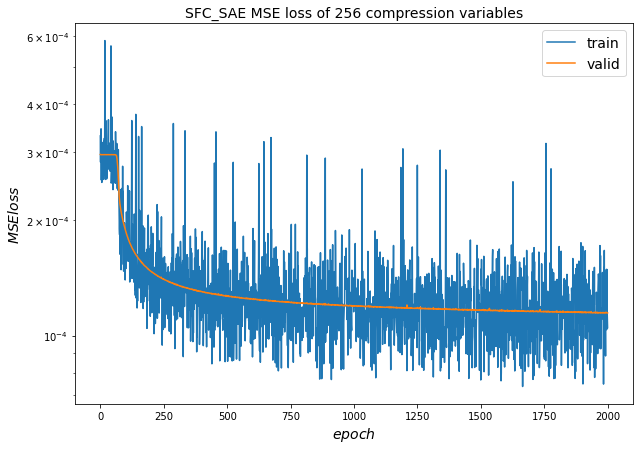

In [31]:
pathName = "./SAE/csv/II_I_Error2000_LV256_B16_n1600_L0.0001.csv"
name = "SFC_SAE MSE loss of 256 compression variables"
PlotMSELoss(pathName,name)